# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs!

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together. This is from 22-23 season, feel free to update to 2023-24 season if you want.
Data Sources:
https://www.basketball-reference.com/leagues/NBA_2024_totals.html # reference for performance data https://www.basketball-reference.com/contracts/players.html # reference for salary data

Details:

Determine a way to use clustering to estimate based on performance if players are under or over paid, generally.

Then select players you believe would be best for your team and explain why. Do so in three categories:

Examples that are not good choices (3 or 4)
Several options that are good choices (3 or 4)
Several options that could work, assuming you can't get the players in the good category (3 or 4)
You will decide the cutoffs for each category, so you should be able to explain why you chose them.

Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations.

Hints:

Salary is the variable you are trying to understand (not to predict, just understand)
When interpreting you might want to use graphs that include variables that are the most correlated with Salary
You'll need to scale the variables before performing the clustering
Be specific about why you selected the players that you did, more detail is better
Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used.
Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.

choose something that best shows salary, 
because there are so many basketball players names, you. might want to encode them (encoding=latin)

In [3]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [4]:
perf_df = pd.read_csv("/workspaces/DS-3021/data/nba_perf_22.csv", encoding = "latin")
nba_salary_df = pd.read_csv("/workspaces/DS-3021/data/nba_salaries_22.csv", encoding = "latin")
perf_df.head()
nba_salary_df.head()

,ï»¿Player,Salary
0,Stephen Curry,"$48,070,014"
1,Russell Westbrook,"$47,063,478"
2,LeBron James,"$44,474,988"
3,Kevin Durant,"$44,119,845"
4,Bradley Beal,"$43,279,250"


# Drop variables that will not be needed or are duplicates

##### clean salaries

In [5]:
#rename the column to remove special characters
nba_salary_df.rename(columns={'ï»¿Player': 'Player'}, inplace=True)

In [6]:
#take out the dollar sign and commas, convert them to numerical values
nba_salary_df['Salary'] = nba_salary_df['Salary'].replace('[\$,]', '', regex=True).astype(float)
nba_salary_df['Player'] = nba_salary_df['Player'].str.strip() #take the spacing between the naes
nba_salary_df.head()


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_681/3365881207.py:2: SyntaxWarning: invalid escape sequence '\$'
  nba_salary_df['Salary'] = nba_salary_df['Salary'].replace('[\$,]', '', regex=True).astype(float)


,Player,Salary
0,Stephen Curry,48070014.0
1,Russell Westbrook,47063478.0
2,LeBron James,44474988.0
3,Kevin Durant,44119845.0
4,Bradley Beal,43279250.0


#### clean performance data

In [12]:
perf_df['Player'] = perf_df['Player'].str.strip() #same thing, take the spacing between the names

#dropped a couples columns that are not necessary and overlapped with others
features = ['G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
new_perf_df = perf_df[features]

new_perf_df.dropna(inplace=True)
new_perf_df.head()


/tmp/ipykernel_681/4126144861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_perf_df.dropna(inplace=True)


,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS
0,73,23.6,0.439,0.359,0.468,0.486,0.595,6.5,1.1,0.5,0.6,1.2,9.1
1,76,26.3,0.547,0.000,0.548,0.547,0.543,10.0,3.4,0.9,0.8,1.5,6.9
2,56,32.6,0.557,0.000,0.562,0.557,0.753,10.1,3.4,1.4,0.8,2.6,19.1
3,32,11.3,0.402,0.125,0.560,0.424,0.625,2.7,0.7,0.2,0.3,0.5,4.1
4,47,22.3,0.550,0.304,0.578,0.566,0.873,5.5,0.9,0.3,1.0,0.9,12.9


#### merge 2 datasets

In [13]:
#merge by matching player names
df = pd.merge(perf_df, nba_salary_df, on='Player', how='inner')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
0,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2840160.0
1,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,17926829.0
2,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,30351780.0
3,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,2094120.0
4,Nickeil Alexander-Walker,SG,23,TOT,65,21,22.6,3.9,10.5,0.372,...,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6,5009633.0


# Run the clustering algo with your best guess for K

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Run KMeans clustering with best guess k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assign cluster labels to dataframe
df['Cluster'] = kmeans.labels_

In [15]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_scaled)


KMeans(n_clusters=2, n_init=10, random_state=42)

# View the results

In [16]:
# Print cluster centers (in scaled feature space)
print("Cluster centers:\n", kmeans.cluster_centers_)

# Print cluster labels for each player
print("Cluster labels:\n", kmeans.labels_)

# Print total within-cluster sum of squares (inertia)
print("Inertia (total WCSS):", kmeans.inertia_)


Cluster centers:
 [[-0.19614061 -0.56997187 -0.02258327 -0.05156324  0.04592355 -0.00788712
  -0.1144259  -0.36798503 -0.49636073 -0.4393878  -0.19674663 -0.54043854
  -0.56166026]
 [ 0.35447099  1.03006965  0.04081314  0.09318657 -0.08299437  0.01425384
   0.2067938   0.66503319  0.89703746  0.79407433  0.3555662   0.97669615
   1.01504866]]
Cluster labels:
 [0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1
 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1
 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0

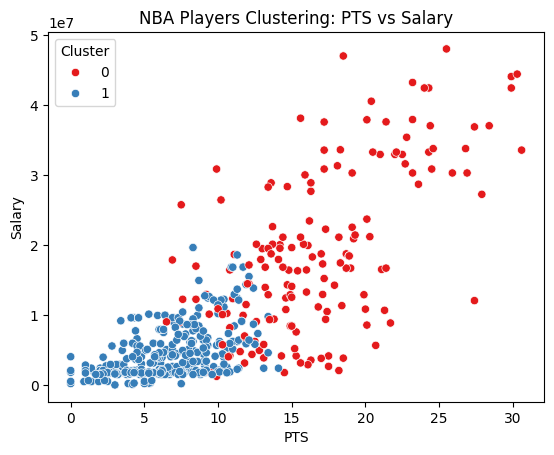

In [38]:
# See how many players are in each cluster
df['Cluster'].value_counts()
# Look at average performance and salary per cluster
df.groupby('Cluster')[['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'G', 'MP', 'Salary']].mean()
# Sort by salary within each cluster to identify hidden gems
df.sort_values(['Cluster', 'Salary']).head(10)
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='PTS', y='Salary', hue='Cluster', palette='Set1')
plt.title('NBA Players Clustering: PTS vs Salary')
plt.show()


In [47]:
# Select numeric features
correlation_df = df[['Salary', 'PTS', 'AST', 'FG','TRB', 'STL', 'BLK', 'TOV', 'G', 'MP']]

# Calculate correlation matrix
correlation_matrix = correlation_df.corr()

# Display
correlation_matrix['Salary'].sort_values(ascending=False)


Salary    1.000000
PTS       0.784472
FG        0.770245
TOV       0.682251
MP        0.676218
AST       0.615907
TRB       0.495766
STL       0.469915
BLK       0.272589
G         0.230218
Name: Salary, dtype: float64

# Create a visualization of the results with 2 or 3 variables that you think will best differentiate the clusters

## this is in 2D

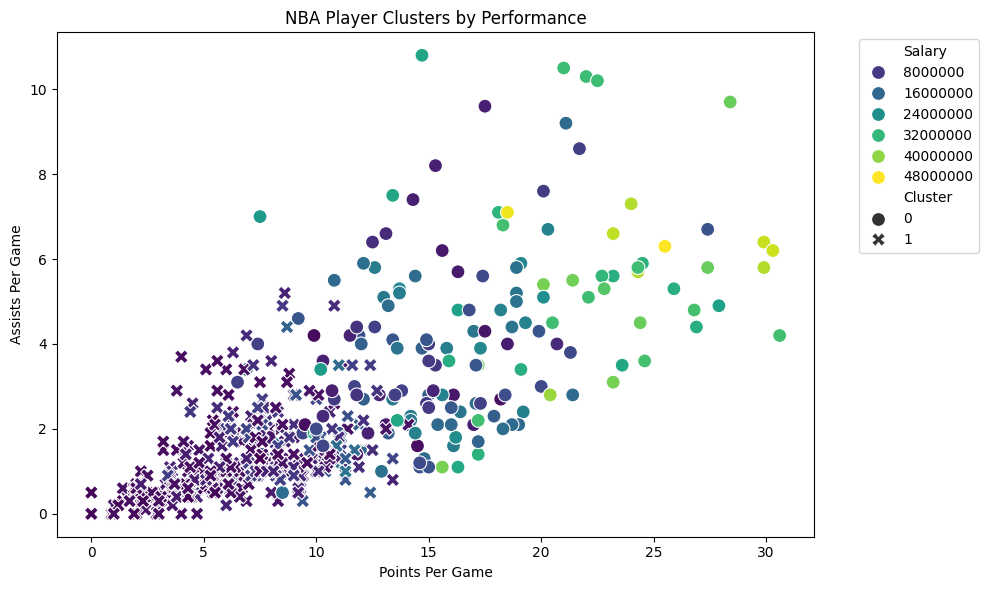

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatterplot with:
# - X-axis: Points
# - Y-axis: Assists
# - Hue: Salary (color gradient)
# - Style: Cluster (marker shape)
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='PTS', 
    y='AST',
    hue='Salary',          # color based on salary
    style='Cluster',       # shape based on cluster
    palette='viridis',     # color gradient
    s=100                  # marker size
)

plt.title("NBA Player Clusters by Performance")
plt.xlabel("Points Per Game")
plt.ylabel("Assists Per Game")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## this is in 3D

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    df, 
    x='PTS', y='AST', z='TRB',  # You can change these to MP, STL, etc.
    color='Salary', 
    hover_name='Player',
    title='NBA Player Performance: PTS vs AST vs TRB (Color = Salary)',
    color_continuous_scale='Viridis'
)
fig.show(renderer="browser")

### ^ i made a 3d plot but you would have to see it and open it on a browser/ a separate tab

# Evaluate the quality of the clustering using total variance explained and silhouette scores

In [29]:
import numpy as np
from sklearn.metrics import silhouette_score

# Total sum of squares (TSS) = total variance from overall mean
tss = np.sum((X_scaled - np.mean(X_scaled, axis=0))**2)

# Within-cluster sum of squares (WCSS) = KMeans inertia
wcss = kmeans.inertia_

# Between-cluster sum of squares (BSS)
bss = tss - wcss

# Variance explained by clustering
var_explained = bss / tss

# Silhouette score for separation quality
sil_score = silhouette_score(X_scaled, kmeans.labels_)

# Print results
print(f"Total Sum of Squares (TSS): {tss:.2f}")
print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.2f}")
print(f"Between-Cluster Sum of Squares (BSS): {bss:.2f}")
print(f"Variance Explained: {var_explained:.2%}")
print(f"Silhouette Score: {sil_score:.3f}")


Total Sum of Squares (TSS): 6058.00
Within-Cluster Sum of Squares (WCSS): 4708.12
Between-Cluster Sum of Squares (BSS): 1349.88
Variance Explained: 22.28%
Silhouette Score: 0.222


# Determine the ideal number of clusters using the elbow method and the silhouette coefficient

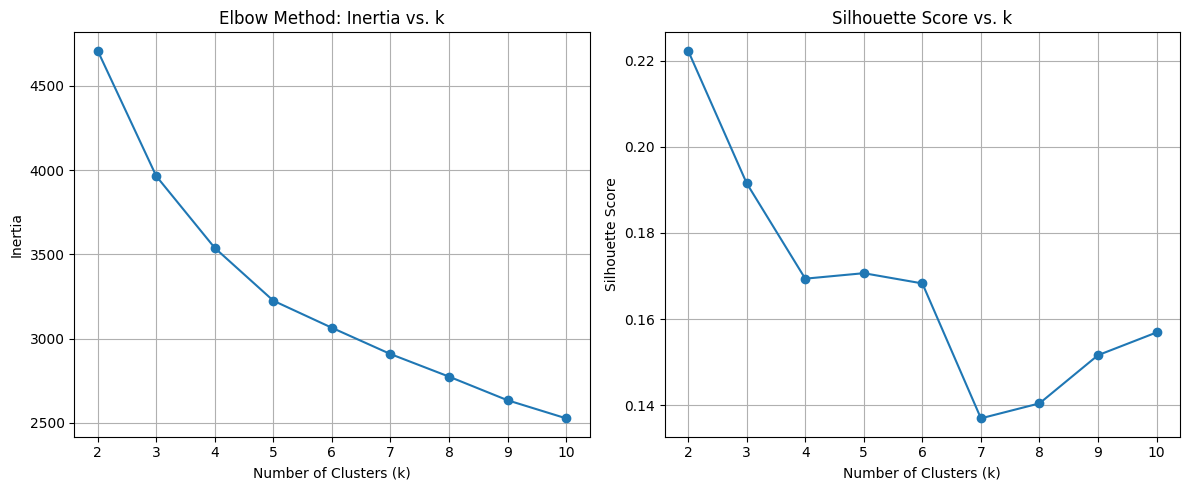

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of cluster counts to test
k_range = range(2, 11)

inertias = []
sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Inertia (Elbow method)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method: Inertia vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


# Visualize the results of the elbow method

# Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

# Once again evaluate the quality of the clustering using total variance explained and silhouette scores

# Use the model to select players for Mr. Rooney to consider

# Write up the results in a separate notebook with supporting visualizations and an overview of how and why you made the choices you did. This should be at least 500 words and should be written for a non-technical audience.